In [1]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import pandas as pd
import json
import os
import py_vncorenlp
from underthesea import sent_tokenize
import numpy as np
from rank_bm25 import BM25Okapi
from numpy.random import normal
from scipy.stats import truncnorm, boxcox, gamma
import matplotlib.pyplot as plt

/home/arch/Projects/college/dsc/dev/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
rdrsegmenter = py_vncorenlp.VnCoreNLP(annotators=["wseg"], save_dir=os.path.abspath('../vncorenlp'))

2023-10-19 08:21:32 INFO  WordSegmenter:24 - Loading Word Segmentation model


In [3]:
tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-large")

In [4]:
data = pd.read_json("../datasets/ise-dsc01-public-test-offcial.json", orient="index")

In [5]:
idx = 32540

In [6]:
text = data.loc[idx]["context"]
claim = data.loc[idx]["claim"]
context = rdrsegmenter.word_segment(text)

In [7]:
def clean_str(s):
    return ''.join(e.lower() if e.isalnum() else " " for e in s)

In [8]:
query = clean_str(claim).split()
query

['thiện',
 'đã',
 'tìm',
 'tòi',
 'về',
 'hệ',
 'điều',
 'hành',
 'linux',
 'và',
 'biết',
 'được',
 'hệ',
 'thống',
 'bên',
 'trong',
 'nó']

In [74]:
[clean_str(doc) for doc in context]

['nguyễn ngọc thiện là học sinh lớp 7 tại trường thcs nguyễn tri phương   huế  ',
 'ngay từ khi còn nhỏ   thiện đã rất thích đọc sách   nghe nhạc và coding   5 tuổi   thiện tiếp xúc với máy tính và thể hiện niềm yêu thích với lĩnh vực này  ',
 'trước khi theo học tại funix   thông quang mạng xã hội   thiện tìm tòi về hệ điều hành linux và biết đến một bản phân phối của người việt phát triển  ',
 'cậu chủ động kết nối với tác giả và nhận được sự hướng dẫn   giảng giải về công nghệ  ',
 'từ đó   thiện thêm niềm cảm hứng về thế giới lập trình  ',
 'càng tìm tòi   học hỏi thiện càng thêm yêu thích lĩnh vực này  ',
 'nam sinh tiếp tục tham gia kode   cộng đồng trẻ đam mê công nghệ thông tin và kết nối với nhiều đàn anh  ',
 'ngọc thiện được hướng dẫn về kỹ thuật làm web cơ bản cùng nhiều kiến thức khác  ',
 'đây cũng là một trong những tiền đề để cậu học trò xứ huế quyết tâm học tập bài bản về lập trình  ',
 '  em rất biết ơn những người thầy đầu tiên đã dẫn dắt em đến với công nghệ thông t

In [10]:
bm25 = BM25Okapi([clean_str(doc).split() for doc in context])

In [11]:
query_score = bm25.get_scores(query=query)
query_score

array([ 0.22487515,  2.13387674, 16.68689254,  2.89878612,  1.54683488,
        5.59622271,  0.44966847,  2.73182269,  2.61834401,  3.40345878,
        0.93102751,  2.14624581,  1.83039064,  3.03579105,  0.        ,
        1.44862466, 18.3916045 ,  1.31128097,  2.68604535,  0.        ,
        1.88081786,  0.72361001,  0.49768864,  3.14428906,  2.69386285,
        0.44966847,  0.        ,  3.04150574,  1.7097487 ,  2.42172443,
        0.        ])

In [108]:
def distribute_score(score, arr_len, pos):
    myclip_a = 0
    myclip_b = 1
    my_mean = pos/arr_len
    my_std = 0.7 / arr_len
    
    a, b = (myclip_a - my_mean) / my_std, (myclip_b - my_mean) / my_std

    x_range = np.linspace(0,1,arr_len)

    y = truncnorm.pdf(x_range, a, b, loc = my_mean, scale = my_std)

    return score*y/sum(y)
    

In [109]:
# final_doc_scores = np.zeros(len(query_score))

final_doc_scores = sum([distribute_score(score,len(query_score), idx) for idx, score in enumerate(query_score)])
sorted_ids = sorted(range(len(context)), key=lambda k: final_doc_scores[k], reverse=True)

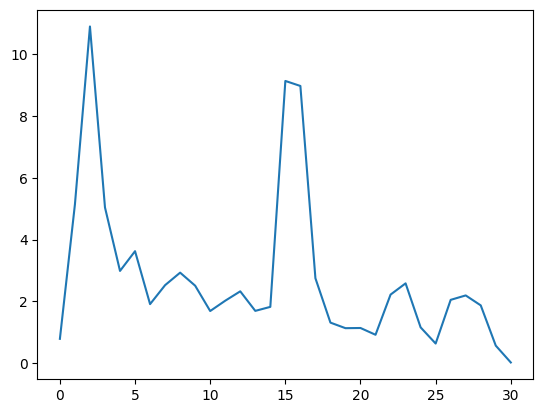

In [110]:
x = range(len(context))

plt.plot(x, final_doc_scores)

In [111]:
claim

'thiện đã tìm tòi về hệ điều hành linux và biết được hệ thống bên trong nó'

In [112]:
[context[i] for i in sorted_ids]

['Trước khi theo học tại FUNiX , thông quang mạng xã_hội , Thiện tìm_tòi về hệ_điều_hành Linux và biết đến một bản phân_phối của người Việt phát_triển .',
 'Mỗi sản_phẩm , nhóm dự_án đều đạt được những thành_quả nhất_định .',
 '" Em đã tích_luỹ thêm nhiều hiểu_biết về Linux - hệ_điều_hành mà em đã dành rất nhiều thời_gian tìm_hiểu .',
 'Ngay từ khi còn nhỏ , Thiện đã rất thích đọc sách , nghe nhạc và coding . 5 tuổi , Thiện tiếp_xúc với máy_tính và thể_hiện niềm yêu thích với lĩnh_vực này .',
 'Cậu chủ_động kết_nối với tác_giả và nhận được sự hướng_dẫn , giảng_giải về công_nghệ .',
 'Càng tìm_tòi , học_hỏi Thiện càng thêm yêu thích lĩnh_vực này .',
 'Từ đó , Thiện thêm niềm cảm_hứng về thế_giới lập_trình .',
 'Đây cũng là một trong những tiền_đề để cậu học_trò xứ Huế quyết_tâm học_tập bài_bản về lập_trình .',
 'Em tin là cứ tích_góp từng ngày như_vậy rồi đến một ngày sẽ tích_luỹ được một kho kiến_thức " , Thiện chia_sẻ thêm .',
 'Cậu định_lượng khối thời_gian cần để học , làm bài , ôn 

In [113]:
claim_tk_length = len(tokenizer(claim).input_ids[:-1])
abstract_len = tokenizer.model_max_length - claim_tk_length - 1
context_tk_length = [len(tokenizer(s).input_ids[:-1]) for s in context]

In [114]:
abstract_len

491

In [115]:
fin_len = 0
mask = [0 for _ in range(len(sorted_ids))]
for i in sorted_ids:
    if fin_len + context_tk_length[i] > abstract_len:
        break
    
    fin_len += context_tk_length[i]
    mask[i] = 1

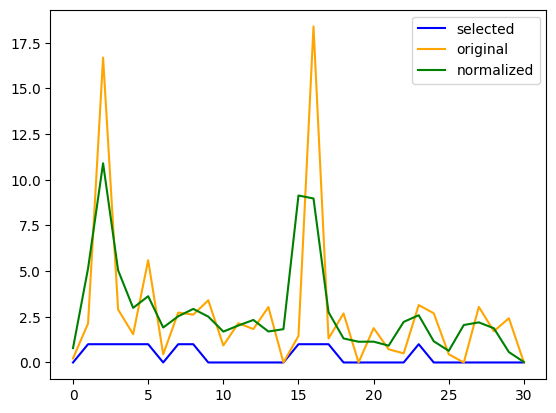

In [116]:
plt.plot(x, mask,color="blue", label="selected")
# original
plt.plot(x, query_score,color="orange",label="original")
# normalized
plt.plot(x, final_doc_scores,color="green", label="normalized")
plt.legend(loc='best')
plt.show()

In [117]:
[context[i] for i in range(len(context)) if mask[i] == 1]

['Ngay từ khi còn nhỏ , Thiện đã rất thích đọc sách , nghe nhạc và coding . 5 tuổi , Thiện tiếp_xúc với máy_tính và thể_hiện niềm yêu thích với lĩnh_vực này .',
 'Trước khi theo học tại FUNiX , thông quang mạng xã_hội , Thiện tìm_tòi về hệ_điều_hành Linux và biết đến một bản phân_phối của người Việt phát_triển .',
 'Cậu chủ_động kết_nối với tác_giả và nhận được sự hướng_dẫn , giảng_giải về công_nghệ .',
 'Từ đó , Thiện thêm niềm cảm_hứng về thế_giới lập_trình .',
 'Càng tìm_tòi , học_hỏi Thiện càng thêm yêu thích lĩnh_vực này .',
 'Ngọc_Thiện được hướng_dẫn về kỹ_thuật làm web cơ_bản cùng nhiều kiến_thức khác .',
 'Đây cũng là một trong những tiền_đề để cậu học_trò xứ Huế quyết_tâm học_tập bài_bản về lập_trình .',
 'Mỗi sản_phẩm , nhóm dự_án đều đạt được những thành_quả nhất_định .',
 '" Em đã tích_luỹ thêm nhiều hiểu_biết về Linux - hệ_điều_hành mà em đã dành rất nhiều thời_gian tìm_hiểu .',
 'Em tin là cứ tích_góp từng ngày như_vậy rồi đến một ngày sẽ tích_luỹ được một kho kiến_thức 

In [118]:
claim

'thiện đã tìm tòi về hệ điều hành linux và biết được hệ thống bên trong nó'